# Plot limb speed vs dLight for all animals

We must account for the speed of the animal's body if we want to independently consider limb speed.

In [1]:
import os
import toml
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from glob import glob
from os.path import join
from scipy import signal
from toolz import partial
from tqdm.auto import tqdm
from rl_analysis.util import zscore
from sklearn.linear_model import LinearRegression
from rl_analysis.plotting import save_factory, setup_plotting_env, fg
from rl_analysis.photometry.signal import rolling_fluor_normalization, rereference

In [2]:
def _partial(df, x, y, window=range(-30, 30)):
    # new approach - remove transfer function here
    X = [df[x].shift(i).rename(index=str(i)) for i in window]
    X = pd.DataFrame(X).T

    X[y] = df[y]
    X = X.dropna()

    mdl = LinearRegression()
    mdl.fit(X.drop(columns=[y]), X[y])
    p = mdl.predict(X.drop(columns=[y]))
    df.loc[X.index, f"{y} partial"] = X[y] - p
    df[f"{y} partial (z)"] = zscore(df[f"{y} partial"])
    return df


# rereference the dLight signal to remove motion artifact
def filter_signal(v):
    sos = signal.butter(2, 3, output="sos", fs=30.)
    f = signal.sosfiltfilt(sos, v)
    return f


def get_z(x, y, bw_adjust=1, subsample_factor=100):
    from scipy.stats import gaussian_kde

    xy = np.vstack([x[::subsample_factor], y[::subsample_factor]])
    kernel = gaussian_kde(xy)
    kernel.set_bandwidth(kernel.scotts_factor() * bw_adjust)
    z = kernel(np.vstack([x, y]))
    return z


def partial_out(df, xs, y):
    assert isinstance(xs, list)
    X = df[xs]
    y = df[y]
    mdl = LinearRegression()
    mdl.fit(X, y)
    p = mdl.predict(X)
    return zscore(y - p)


def compute_keypoint_velocity(kp, n=2):
    return (kp[n:] - kp[:-n]) / n


def compute_global_velocity(kp, n=2):
    # nframes X nkeypoints X 3
    kp = np.nanmean(kp[:, :3], axis=1)
    v = (kp[n:] - kp[:-n]) / n
    # only consider the first 3 points as they are the spine
    return np.linalg.norm(v, axis=1)

In [3]:
with open("../analysis_configuration.toml", "r") as f:
    config = toml.load(f)
dlight_config = config['dlight_basic_analysis']

setup_plotting_env()

saver = save_factory(join(config['figures']['store_dir'], 'keypoint-analysis'), tight_layout=False)

## Image showing keypoints

In [4]:
image = joblib.load(join(config['raw_data']['keypoints'], 'video-image.p'))

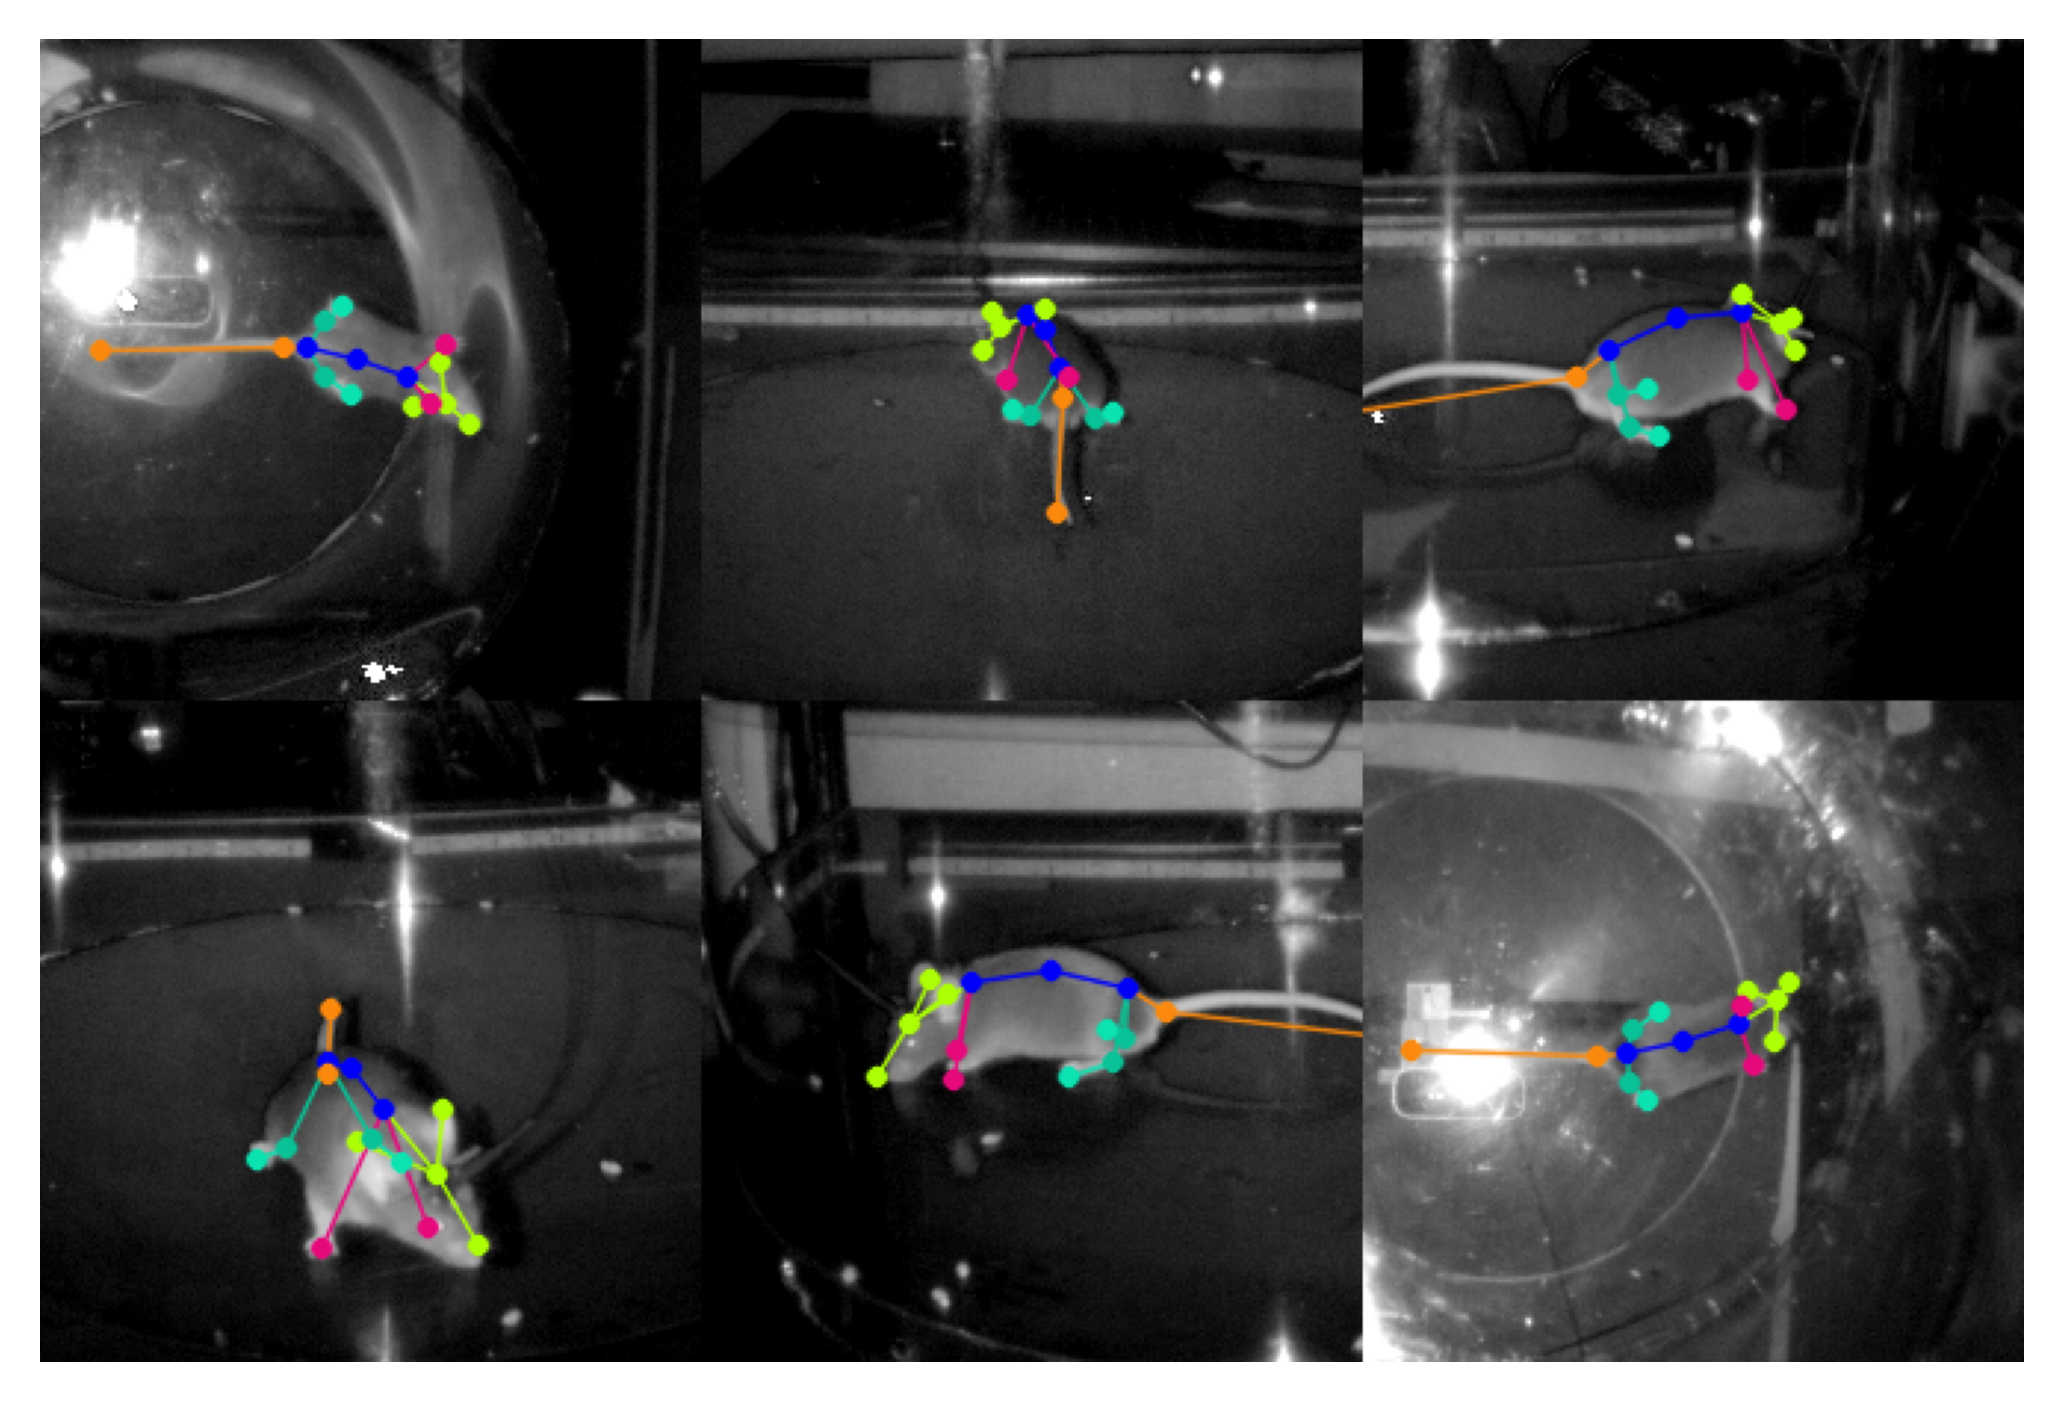

In [5]:
plt.imshow(image)
plt.axis('off')
fig = plt.gcf()
saver(fig, 'keypoint-image');

In [6]:
data = {
    os.path.basename(k): joblib.load(k)
    for k in glob(join(config['raw_data']['keypoints'], "photometry-dls-dlight-*.p"))
}

In [7]:
list(data)

['photometry-dls-dlight-12.p',
 'photometry-dls-dlight-13.p',
 'photometry-dls-dlight-11.p',
 'photometry-dls-dlight-9.p',
 'photometry-dls-dlight-10.p']

In [8]:
window = range(-10, 10)
dfs = {}

for k, v in data.items():

    speed = compute_global_velocity(v["positions_median"])
    kp_vels = compute_keypoint_velocity(v["positions_median"])
    kp_speed = np.linalg.norm(kp_vels, axis=2)

    speed_2d = compute_global_velocity(v["positions_median"][..., :2])
    kp_vels_2d = compute_keypoint_velocity(v["positions_median"][..., :2])
    kp_speed_2d = np.linalg.norm(kp_vels_2d, axis=2)

    dlight_df = pd.DataFrame(
        {
            "dLight": rolling_fluor_normalization(v["dlight"][2:], normalizer="zscore"),
            "body speed 3d": speed,
            "right forepaw 3d": kp_speed[:, 14],
            "left forepaw 3d": kp_speed[:, 13],
            "right hindpaw 3d": kp_speed[:, 12],
            "left hindpaw 3d": kp_speed[:, 10],
            "forelimb speed 3d": np.nanmean(kp_speed[:, [13, 14]], axis=1),
            "hindlimb speed 3d": np.nanmean(kp_speed[:, [10, 12]], axis=1),
            "body speed 2d": speed_2d,
            "right forepaw 2d": kp_speed_2d[:, 14],
            "left forepaw 2d": kp_speed_2d[:, 13],
            "right hindpaw 2d": kp_speed_2d[:, 12],
            "left hindpaw 2d": kp_speed_2d[:, 10],
            "forelimb speed 2d": np.nanmean(kp_speed_2d[:, [13, 14]], axis=1),
            "hindlimb speed 2d": np.nanmean(kp_speed_2d[:, [10, 12]], axis=1),
            "mouse": k,
        }
    )
    y = []

    for dimension in ("2d", "3d"):
        X = [dlight_df[f"body speed {dimension}"].shift(i) for i in window]
        X = pd.DataFrame(np.array(X).T, columns=map(str, window), index=dlight_df.index)

        X[f"forelimb speed {dimension}"] = dlight_df[f"forelimb speed {dimension}"]
        X = X.dropna()

        mdl = LinearRegression()

        mdl.fit(
            X.drop(columns=[f"forelimb speed {dimension}"]),
            X[[f"forelimb speed {dimension}"]],
        )

        X[f"forelimb partial {dimension}"] = (
            X[f"forelimb speed {dimension}"]
            - mdl.predict(X.drop(columns=[f"forelimb speed {dimension}"])).squeeze()
        )
        X[f"forelimb partial {dimension} (z)"] = zscore(X[f"forelimb partial {dimension}"])
        X[f"forelimb speed {dimension} (z)"] = zscore(X[f"forelimb speed {dimension}"])
        if dimension == "2d":
            X["dLight"] = dlight_df["dLight"]
            X["dLight (z)"] = zscore(X["dLight"])
            X["timestamp"] = np.arange(len(X)) / 30
            X["mouse_id"] = k
        X[f"speed {dimension} (z)"] = zscore(X["0"])

        y.append(X.drop(columns=map(str, window)))
    dfs[k] = pd.concat(y, axis=1)

df = pd.concat(dfs.values())

## Compute correlation across bins

In [9]:
mapping = {
    0: 'spine',
    1: 'spine',
    2: 'spine',
    3: 'tail base',
    4: 'tail tip',
    5: 'head center',
    6: 'left ear',
    7: 'right ear',
    8: 'noce',
    9: 'left hind ankle',
    10: 'left hindpaw',
    11: 'right hind ankle',
    12: 'right hindpaw',
    13: 'left forepaw',
    14: 'right forepaw',
}

In [11]:
def bin_data(
    data, timescale, n_offsets=0, neural_agg="mean", data_agg="mean", window=range(-15, 15)
):
    step = timescale / (n_offsets + 1)
    offsets = np.arange(0, timescale, step)

    time = np.arange(0, 1500, timescale)  # step through 0-1500 seconds at this timescale

    aggs = []
    for offset in offsets:
        cuts = (
            pd.cut(data["timestamp"], time + offset, labels=False)
            .astype("Int16")
            .rename("time bin")
        )
        data['time bin'] = cuts
        agg = data.groupby(["mouse_id", "time bin"]).agg(neural_agg)
        agg["offset"] = offset
        aggs.append(agg)
    agg_matrix = pd.concat(aggs).reset_index()
    agg_matrix["timescale"] = timescale
    agg_matrix = agg_matrix.sort_values(by=["mouse_id", "timestamp"])

    # partial out velocity
    for dim in ("2d", "3d"):
        agg_matrix = agg_matrix.groupby("mouse_id", group_keys=False).apply(
            _partial, x=f"body speed {dim} (z)", y=f"forelimb speed {dim} (z)", window=window
        )
    # partial out 2d velocity from 3d forelimb speed
    agg_matrix = agg_matrix.groupby("mouse_id", group_keys=False).apply(
        _partial, x="body speed 2d (z)", y="forelimb speed 3d (z)", window=window
    )
    # partial velocity from dlight
    agg_matrix = agg_matrix.groupby("mouse_id", group_keys=False).apply(
        _partial, x="body speed 2d (z)", y="dlight_reref_dff (z)", window=window
    )

    if isinstance(neural_agg, str):
        agg_matrix["neural_agg"] = neural_agg
    elif hasattr(neural_agg, "__name__"):
        agg_matrix["neural_agg"] = neural_agg.__name__

    return agg_matrix

## Correlation between dLight and forelimb speed at 300 ms

### Rereference dLight signal: remove motion artifact

In [12]:
secs = 30 * 10
threshold = 1.96
window = range(-secs, secs)
dff_func = partial(rolling_fluor_normalization, window_size=5, quantile=0.1, normalizer="dff")
dfs = {}

for k, v in tqdm(data.items()):

    speed = compute_global_velocity(v["positions_median"])
    kp_vels = compute_keypoint_velocity(v["positions_median"])
    kp_speed = np.linalg.norm(kp_vels, axis=2)

    speed_2d = compute_global_velocity(v["positions_median"][..., :2])
    kp_vels_2d = compute_keypoint_velocity(v["positions_median"][..., :2])
    kp_speed_2d = np.linalg.norm(kp_vels_2d, axis=2)

    signal_dff = dff_func(v["dlight"][2:])
    reference_dff = dff_func(v["uv"][2:])

    dlight_df = pd.DataFrame(
        {
            "dlight_dff": signal_dff,
            "reference_dff": reference_dff,
            "body speed 3d": speed,
            "right forepaw 3d": kp_speed[:, 14],
            "left forepaw 3d": kp_speed[:, 13],
            "right hindpaw 3d": kp_speed[:, 12],
            "left hindpaw 3d": kp_speed[:, 10],
            "forelimb speed 3d": np.nanmean(kp_speed[:, [13, 14]], axis=1),
            "hindlimb speed 3d": np.nanmean(kp_speed[:, [10, 12]], axis=1),
            "body speed 2d": speed_2d,
            "right forepaw 2d": kp_speed_2d[:, 14],
            "left forepaw 2d": kp_speed_2d[:, 13],
            "right hindpaw 2d": kp_speed_2d[:, 12],
            "left hindpaw 2d": kp_speed_2d[:, 10],
            "forelimb speed 2d": np.nanmean(kp_speed_2d[:, [13, 14]], axis=1),
            "hindlimb speed 2d": np.nanmean(kp_speed_2d[:, [10, 12]], axis=1),
            "height": v["positions_median"][2:, 5, 2],
            "mouse_id": k,
            "timestamp": np.arange(len(speed)) / 30,
        }
    )
    nans = dlight_df["dlight_dff"].isna()
    x = dlight_df.loc[~nans]
    dlight_df["dlight_reref_dff"] = rereference(
        pd.Series(filter_signal(x["reference_dff"]), index=x.index),
        x["dlight_dff"],
        center=False,
        clip=False,
    )["rereference"]
    dlight_df["dlight_reref_dff"] = rolling_fluor_normalization(
        dlight_df["dlight_reref_dff"], normalizer="zscore", window_size=20
    )
    z_cols = [x for x in dlight_df.columns if x not in ("mouse_id", "timestamp")]

    dlight_df[[f"{c} (z)" for c in z_cols]] = zscore(dlight_df[z_cols])
    dlight_df["peak_rate_cross"] = 0
    z = dlight_df["dlight_reref_dff (z)"].to_numpy()
    dlight_df.loc[dlight_df.index[1:], "peak_rate_cross"] = (z[:-1] < threshold) & (
        z[1:] > threshold
    )
    y = []

    # partial body speed from dLight
    dlight_df = _partial(dlight_df, x="body speed 2d (z)", y="dlight_reref_dff (z)", window=window)

    dfs[k] = dlight_df
df = pd.concat(dfs.values())
df["peak_rate_cross"] = df["peak_rate_cross"].astype(float)

  0%|          | 0/5 [00:00<?, ?it/s]

## Correlation between dLight and forelimb speed at 300 ms

In [13]:
results = bin_data(data=df, timescale=0.4, n_offsets=0, window=range(1))

forelimb_partial = results.groupby("mouse_id", sort=False).apply(
    partial_out,
    xs=[
        "height",
        "body speed 2d",
        "body speed 3d",
    ],
    y="forelimb speed 3d",
)
results["forelimb_partial"] = forelimb_partial.droplevel(0)

forelimb_partial = results.groupby("mouse_id", sort=False).apply(
    partial_out,
    xs=[
        "height",
        "body speed 2d",
        "body speed 3d",
    ],
    y="dlight_reref_dff (z)",
)
results["dlight_partial"] = forelimb_partial.droplevel(0)

corrs = results.groupby(['timescale', 'mouse_id', 'neural_agg']).corr(method="pearson")
corrs.index = corrs.index.rename("feature", level=-1)

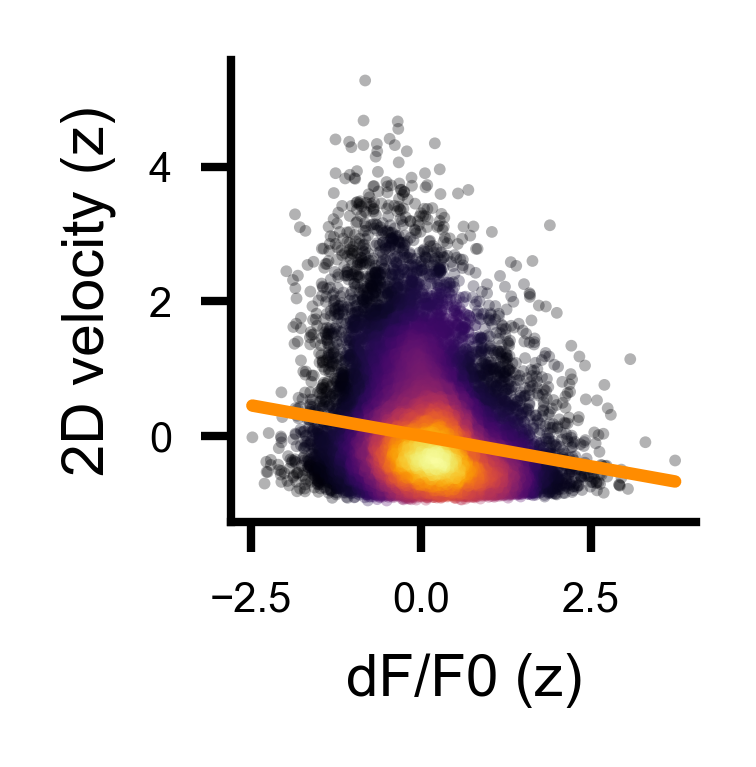

In [14]:
tmp = results.dropna()
x = tmp["dlight_reref_dff (z)"]
y = tmp["body speed 2d (z)"]
z = get_z(x, y, 1, subsample_factor=100)

fig = fg(1, 1)
fig.dpi = 300
plt.scatter(x, y, c=z, s=2, alpha=0.3, cmap="inferno", linewidths=0)
ax = sns.regplot(
    data=results,
    x="dlight_reref_dff (z)",
    y="body speed 2d (z)",
    n_boot=100,
    line_kws=dict(color="darkorange"),
    ci=95,
    scatter=False,
)
ax.set(ylabel="2D velocity (z)", xlabel="dF/F0 (z)")
sns.despine()
saver(fig, "dlight-vs-velocity");

In [15]:
dlight_to_vel_corrs = corrs.xs("dlight_reref_dff (z)", level="feature")

c_ave = dlight_to_vel_corrs.groupby(["mouse_id", "timescale", "neural_agg"]).mean()
c_ave = c_ave.melt(ignore_index=False)

c_ave.groupby("variable").mean().loc[
    [
        "forelimb speed 3d",
        "forelimb speed 3d (z)",
        "body speed 2d",
        "body speed 2d (z)",
        "forelimb_partial",
    ]
]

,value
variable,
forelimb speed 3d,-0.174003
forelimb speed 3d (z),-0.174003
body speed 2d,-0.162466
body speed 2d (z),-0.162466
forelimb_partial,-0.036081


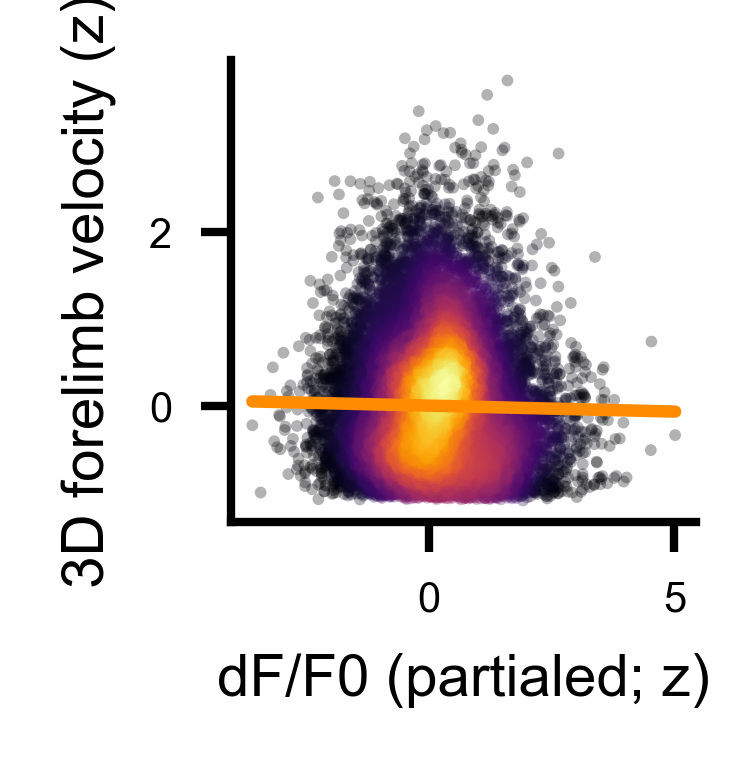

In [16]:
tmp = results.dropna()
x = tmp["dlight_partial"]
y = tmp["forelimb speed 3d (z)"]
z = get_z(x, y, 1, subsample_factor=100)

fig = fg(1, 1)
fig.dpi = 300
plt.scatter(x, y, c=z, s=2, alpha=0.3, cmap="inferno", linewidths=0)
ax = sns.regplot(
    data=results,
    x="dlight_partial",
    y="forelimb speed 3d (z)",
    n_boot=100,
    line_kws=dict(color="darkorange"),
    ci=95,
    scatter=False,
)
ax.set(ylabel="3D forelimb velocity (z)", xlabel="dF/F0 (partialed; z)")
sns.despine()
saver(fig, "partialed-dlight-vs-forelimb-velocity");

In [17]:
dlight_to_vel_corrs = corrs.xs("dlight_partial", level="feature")

c_ave = dlight_to_vel_corrs.groupby(["mouse_id", "timescale", "neural_agg"]).mean()
c_ave = c_ave.melt(ignore_index=False)

c_ave.groupby("variable").mean().loc[
    [
        "forelimb speed 3d",
        "forelimb speed 3d (z)",
        "body speed 2d",
        "body speed 2d (z)",
        "forelimb_partial",
    ]
]

,value
variable,
forelimb speed 3d,-1.863476e-02
forelimb speed 3d (z),-1.863476e-02
body speed 2d,3.576260e-08
body speed 2d (z),3.536856e-08
forelimb_partial,-3.699269e-02


## Timescale correlations

In [18]:
def bin_data(data, timescale, n_offsets=0, neural_agg="mean", window=range(-15, 15)):
    step = timescale / (n_offsets + 1)
    offsets = np.arange(0, timescale, step)

    time = np.arange(0, 1500, timescale)  # step through 0-1500 seconds at this timescale

    aggs = []
    for offset in offsets:
        cuts = (
            pd.cut(data["timestamp"], time + offset, labels=False)
            .astype("Int16")
            .rename("time bin")
        )
        data["time bin"] = cuts
        agg = data.groupby(["mouse_id", "time bin"])[
            ["dlight_dff (z)", "dlight_reref_dff (z)", "body speed 2d (z)", "timestamp", "peak_rate_cross"]
        ].agg(neural_agg)
        agg["offset"] = offset
        aggs.append(agg)
    agg_matrix = pd.concat(aggs).reset_index()
    agg_matrix["timescale"] = timescale
    agg_matrix = agg_matrix.sort_values(by=["mouse_id", "timestamp"])
    if isinstance(neural_agg, str):
        agg_matrix["neural_agg"] = neural_agg
    return agg_matrix

In [19]:
timescales = np.arange(*dlight_config['timescale_correlation']['bins'])

func = partial(bin_data, data=df, n_offsets=4, window=range(1))
results_list = [func(timescale=t) for t in tqdm(timescales)]

results = pd.concat(results_list)

corrs = results.groupby(["timescale", "mouse_id", "neural_agg"]).corr(method="pearson")
corrs.index = corrs.index.rename("feature", level=-1)

  0%|          | 0/120 [00:00<?, ?it/s]

In [20]:
# deal with coupling (i.e., head height)
# partial 2d speed from 3d forelimb speed

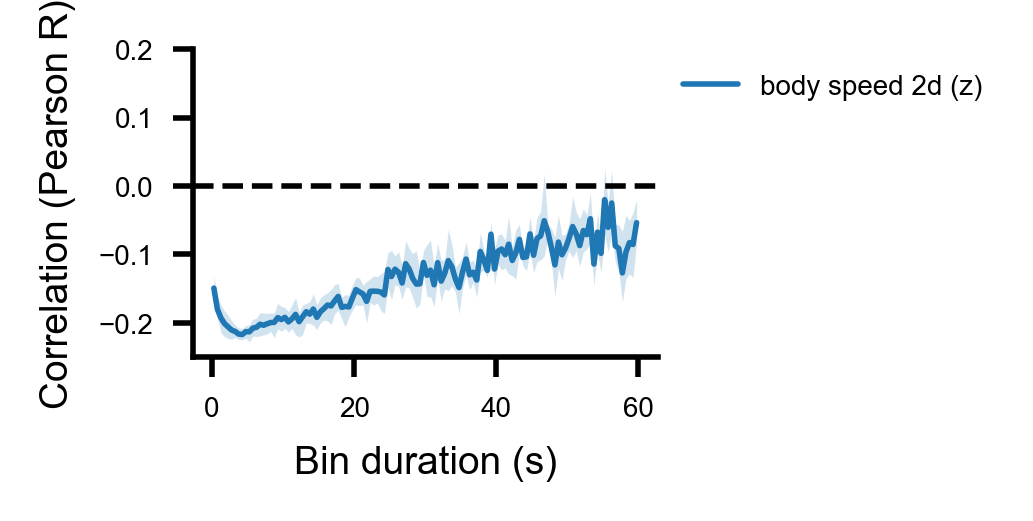

In [21]:
dlight_to_vel_corrs = corrs.xs("dlight_reref_dff (z)", level="feature")
# dlight_to_vel_corrs = corrs.xs("dlight_dff", level="feature")

c_ave = dlight_to_vel_corrs.groupby(['mouse_id', 'timescale', 'neural_agg']).mean()
c_ave = c_ave.melt(ignore_index=False)

fig = fg(1.5, 1)
fig.dpi = 200
ax = sns.lineplot(
    data=c_ave.reset_index(),
    x="timescale",
    y="value",
    hue="variable",
    n_boot=100,
    hue_order=["body speed 2d (z)"],
    errorbar=('ci', 68),
    err_kws=dict(lw=0),
)
ax.axhline(0, ls="--", c="k")
ax.set(ylabel="Correlation (Pearson R)", xlabel="Bin duration (s)", ylim=(-0.25, 0.2))
plt.legend(frameon=False, loc="upper left", bbox_to_anchor=(1, 1))
sns.despine()
saver(fig, "2d-velocity-vs-dlight");

### Peak rate timescale plot

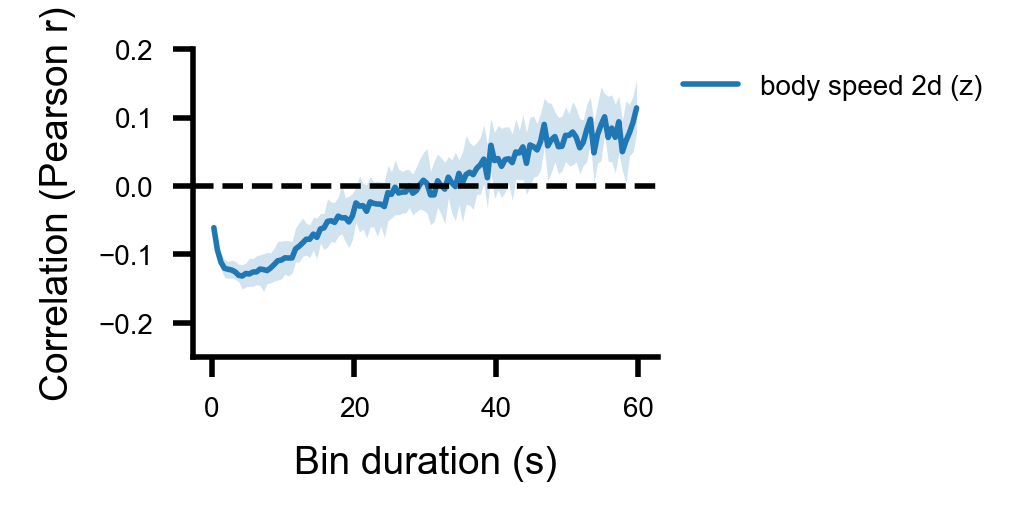

In [22]:
dlight_to_vel_corrs = corrs.xs("peak_rate_cross", level="feature")

c_ave = dlight_to_vel_corrs.groupby(['mouse_id', 'timescale', 'neural_agg']).mean()
c_ave = c_ave.melt(ignore_index=False)

fig = fg(1.5, 1)
fig.dpi = 200
ax = sns.lineplot(
    data=c_ave.reset_index(),
    x="timescale",
    y="value",
    hue="variable",
    n_boot=100,
    hue_order=["body speed 2d (z)"],
    errorbar=('ci', 68),
    err_kws=dict(lw=0),
)
ax.axhline(0, ls="--", c="k")
ax.set(ylabel="Correlation (Pearson r)", xlabel="Bin duration (s)", ylim=(-0.25, 0.2))
plt.legend(frameon=False, loc="upper left", bbox_to_anchor=(1, 1))
sns.despine()
saver(fig, "2d-velocity-vs-dlight-peaks");